# Trained model evaluation

## Processing

### Early convnet

In [25]:
from src.data.pipelines import convnet_pipeline
from src.models import early_convnet
from tabulate import tabulate

import tensorflow as tf
import matplotlib.pyplot as plt

import os

#### Pipeline

In [2]:
BATCH_SIZE_IMAGES = 1
BATCH_SIZE_PATCHES = 1
IMAGE_SIZE = 224
PATCH_SIZE = 40
PATCH_SIZE_ANNOTATION = 2
PATCH_STRIDE = 1
SLICE_TRAIN = ':1'
SLICE_VALID = ':1'
SLICE_TEST = '85%:'

In [3]:
input_pipeline = convnet_pipeline.ConvnetPipeline(
    SLICE_TRAIN,
    SLICE_VALID,
    SLICE_TEST,
    BATCH_SIZE_IMAGES,
    BATCH_SIZE_PATCHES,
    IMAGE_SIZE,
    PATCH_SIZE,
    PATCH_SIZE_ANNOTATION,
    PATCH_STRIDE
)

2024-02-20 20:57:27.254081: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


#### Model

In [4]:
model = early_convnet.EarlyConvnet()
model.build((None, PATCH_SIZE + 20, PATCH_SIZE + 20, 3))     # 20 is for mirror padding border
checkpoint_filepath = os.path.join(os.getcwd(),'..', 'models', 'ckpt', 'early_convnet')
latest = tf.train.latest_checkpoint(checkpoint_filepath)

model.load_weights(latest)

### Metrics and evaluation

In [27]:
class MetricTracker:
    def __init__(self, model_name):
        self.model_name = model_name
        self.mIoU = tf.keras.metrics.OneHotMeanIoU(
            num_classes = 7,
            name = f'mIoU_{model_name}'
        )
        self.class_names = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
        self.IoU_scores = [tf.keras.metrics.OneHotIoU(
            num_classes = 7,
            name = f'IoU_{model_name}_{self.class_names[i]}',
            target_class_ids = [i]
        ) for i in range(7)]
        
    def update_state(self, mask, mask_pred):
        self.mIoU.update_state(mask, mask_pred)
        for metric in self.IoU_scores:
            metric.update_state(mask, mask_pred)

    def result(self):
        table = [['all (mIoU)', self.mIoU.result().numpy()]]
        for i,m in enumerate(self.IoU_scores):
            table.append([self.class_names[i], m.result().numpy()])
                          
        print(tabulate(table, headers=['class', 'score']))

In [19]:
tracker = MetricTracker('convnet')

In [20]:
def index_to_rgb(indexed_image):
    palette = [
        [0, 255, 255],   # urban_land
        [255, 255, 0],   # agriculture_land
        [255, 0, 255],   # rangeland
        [0, 255, 0],     # forest_land
        [0, 0, 255],     # water
        [255, 255, 255], # barren_land
        [0, 0, 0]        # unknown
    ]

    # Convert indexed image to one-hot representation
    one_hot_map = tf.one_hot(tf.squeeze(indexed_image, axis=-1), depth=len(palette), dtype=tf.float32)

    # Use one-hot map and palette to reconstruct RGB image
    reconstructed_image = tf.reduce_sum(tf.expand_dims(one_hot_map, axis=-1) * tf.constant(palette, dtype=tf.float32), axis=-2)

    return tf.cast(reconstructed_image, dtype=tf.uint8)

In [8]:
def display(display_list, file_name):
    plt.figure(figsize=(5, 5))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    print(len(display_list))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        data = display_list[i][0]
        # if i > 0:
        #     data = index_to_rgb(data)
        plt.imshow(tf.keras.utils.array_to_img(data, data_format='channels_last'))
        plt.axis('off')
    plt.suptitle(file_name[0].numpy())
    plt.show()

In [26]:
tracker.result()

class                score
----------------  --------
all (mIoU)        0.205759
urban land        0.596495
agriculture land  0.118293
rangeland         0
forest_land       0.205869
water             0.313901
barren_land       0
unknown           0


3


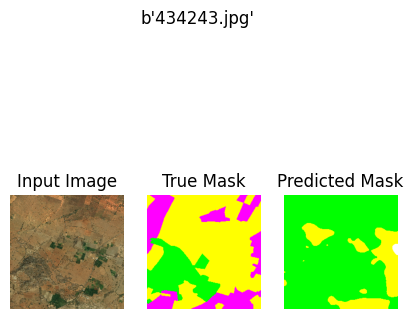

3


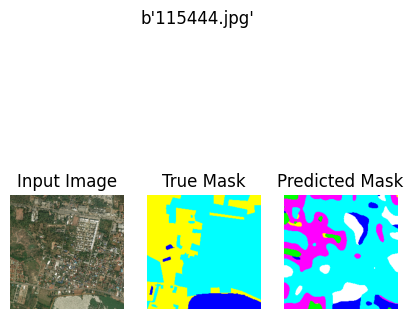

In [21]:
for patches, _, img, mask, file_name in input_pipeline.test.take(2):
    pred = model.predict(patches, verbose=0)
    mask_pred = tf.reshape(pred, shape=(1, 225, 225, 7))
    # "lose" the extra pixel: 225 => 224
    mask_pred = tf.image.crop_to_bounding_box(
            image=mask_pred,
            offset_height=0,
            offset_width=0,
            target_height=224,
            target_width=224
        )
    tracker.update_state(mask, mask_pred)
    mask_indexed = tf.reshape(tf.argmax(input=mask, axis=3), shape=(1, 224, 224, 1))
    pred_indexed = tf.reshape(tf.argmax(input=mask_pred, axis=3), shape=(1, 224, 224, 1))
    mask_rgb = index_to_rgb(mask_indexed)
    pred_rgb = index_to_rgb(pred_indexed)
    
    display((img, mask_rgb, pred_rgb), file_name)

### FCN-8s

### U-Net

## Comparison